In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
%matplotlib inline


Device:  cuda


In [8]:
'''
Dataset for training:
+ 2D Kolmogorov flow
+ 2D grids 256*256
+ 40 Trajectories
+ 320 Time steps per trajectory
+ The data is in "./Re1000_40Trajectory_320Step_256_256.npy"
+ The dimantionality of the numpy file is (40,320,256,256)
+ Reynolds number 1000
'''
class NumpyDataset(Dataset):
    def __init__(self, file_path):
        data = np.load(file_path)
        data = data[:-4]
        print(data.shape)
        # Reshape the data to create individual samples
        self.data = data.reshape(-1, 256, 256)
        # Normalize the data to [-1, 1]
        self.data = 2 * (self.data - np.min(self.data)) / (np.max(self.data) - np.min(self.data)) - 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        image = np.expand_dims(image, axis=0)  # Add channel dimension
        return torch.tensor(image, dtype=torch.float32)

# Load the full dataset
full_dataset = NumpyDataset("/home/baris/Documents/DDSim/Diffusion-based-Fluid-Super-resolution/data/kf_2d_re1000_256_40seed.npy")

# Select 10% of the dataset
percentage = 1.0
subset_size = int(percentage * len(full_dataset))
subset_indices = random.sample(range(len(full_dataset)), subset_size)
subset_dataset = Subset(full_dataset, subset_indices)

dataloader = DataLoader(subset_dataset, batch_size=32, shuffle=True)


(36, 320, 256, 256)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/dm_exercise_share/kolmogorov-flow4.png'

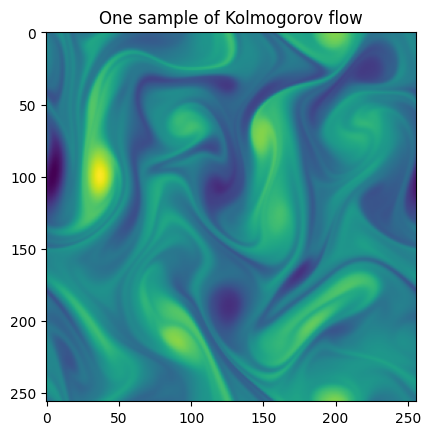

In [9]:
'''
Show example of the flow file of the dataset
'''
def show_sample_image(dataset):
    idx = random.randint(0, len(dataset) - 1)
    image = dataset[idx]
    plt.imshow(image[0])
    plt.title('One sample of Kolmogorov flow')
    plt.savefig("/content/drive/MyDrive/dm_exercise_share/kolmogorov-flow4",dpi=300)
    #plt.show()

# Display a sample image from the subset dataset
show_sample_image(subset_dataset)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
'''
The Unet class definition
'''
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.down1 = nn.Sequential(nn.Conv2d(2, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)

        self.middle = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.Conv2d(256, 256, 3, padding=1), nn.ReLU())

        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 2, stride=2), nn.ReLU())
        self.conv_up1 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())

        self.up2 = nn.Sequential(nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU())
        self.conv_up2 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        down1 = self.down1(x)
        pool1 = self.pool1(down1)
        down2 = self.down2(pool1)
        pool2 = self.pool2(down2)

        middle = self.middle(pool2)

        up1 = self.up1(middle)
        up1 = torch.cat((up1, down2), dim=1)
        up1 = self.conv_up1(up1)

        up2 = self.up2(up1)
        up2 = torch.cat((up2, down1), dim=1)
        up2 = self.conv_up2(up2)

        return self.final(up2)

model = SimpleUNet().to(device)


In [11]:
'''
Count the total number of parameters
'''
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total number of parameters: {count_parameters(model)}')


Total number of parameters: 1862273


In [10]:
'''
Training
'''
def loss_fn(predicted_noise, true_noise):
    return ((predicted_noise - true_noise) ** 2).mean()

# Define a linear noise schedule
timesteps = 1000
betas = torch.linspace(1e-4, 0.02, timesteps).to(device)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

optimizer = optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.999))
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma= 0.5)

optimizer_state_dict = torch.load("unconditional_models/with_timestep_input/optimizer_epoch81.pth")
scheduler_state_dict = torch.load("unconditional_models/with_timestep_input/lr_scheduler_epoch81.pth")
optimizer.load_state_dict(optimizer_state_dict)
scheduler.load_state_dict(scheduler_state_dict)

state_dict = torch.load('unconditional_models/with_timestep_input/fixed_output_trained_model_epoch81.pth', map_location=torch.device('cpu'), weights_only=True)
model.load_state_dict(state_dict)
model.to(device)

epochs = 500
losses = []

for epoch in range(epochs):
    epoch_losses = []
    for images in dataloader:
        images = images.to(device)

        # Randomly select a timestep
        t = torch.randint(0, timesteps, (images.size(0),1,1,1), device=device).long()
        nomalized_t = t / (timesteps)
        time_step_channel = torch.ones_like(images) * nomalized_t
        time_step_channel = time_step_channel.to(device)

        # Add noise according to the schedule
        noise = torch.randn_like(images)
        alpha_t_bar = alphas_cumprod[t].view(-1, 1, 1, 1)
        noisy_images = torch.sqrt(alpha_t_bar) * images + torch.sqrt(1 - alpha_t_bar) * noise
        
        x_t_with_time_step = torch.cat((noisy_images, time_step_channel), dim=1)

        optimizer.zero_grad()
        predicted_noise = model(x_t_with_time_step)
        loss = loss_fn(predicted_noise, noise)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    average_loss = np.mean(epoch_losses)
    losses.append(average_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss}")
    if epoch % 100 == 0 and epoch > 0:
        torch.save(model.state_dict(), f'unconditional_models/with_timestep_input/fixed_output_trained_model_epoch{epoch}.pth')
    scheduler.step()
    
# Plot the loss after training
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


torch.save(model.state_dict(), 'unconditional_models/with_timestep_input/fixed_output_trained_model_epoch{epoch}.pth')

Epoch 1/500, Loss: 0.005025481931968696
Epoch 2/500, Loss: 0.005098687239094741
Epoch 3/500, Loss: 0.005088090647607007
Epoch 4/500, Loss: 0.0050136320609858055
Epoch 5/500, Loss: 0.005101407984814917
Epoch 6/500, Loss: 0.005164755253483437
Epoch 7/500, Loss: 0.0051050260753577785
Epoch 8/500, Loss: 0.005105881579220295
Epoch 9/500, Loss: 0.005063543322224481
Epoch 10/500, Loss: 0.0051901011598399945
Epoch 11/500, Loss: 0.0050688872210836655
Epoch 12/500, Loss: 0.005171683223064368
Epoch 13/500, Loss: 0.005098520142362556
Epoch 14/500, Loss: 0.005111084049308879
Epoch 15/500, Loss: 0.005006854740592341
Epoch 16/500, Loss: 0.005061023486390089
Epoch 17/500, Loss: 0.004989167021833257
Epoch 18/500, Loss: 0.00504085607179958
Epoch 19/500, Loss: 0.005072872528883939
Epoch 20/500, Loss: 0.00510039228376829
Epoch 21/500, Loss: 0.00500879062520754
Epoch 22/500, Loss: 0.005076166005003163
Epoch 23/500, Loss: 0.00504075087632777
Epoch 24/500, Loss: 0.005038379280207058
Epoch 25/500, Loss: 0.005

KeyboardInterrupt: 

In [15]:
torch.save(model.state_dict(), 'unconditional_models/with_timestep_input/fixed_output_trained_model_epoch108.pth')
torch.save(scheduler.state_dict(), 'unconditional_models/with_timestep_input/lr_scheduler_epoch108.pth')
torch.save(optimizer.state_dict(), 'unconditional_models/with_timestep_input/optimizer_epoch108.pth')

In [12]:
'''
Reading the pretrained parameters
'''
model = SimpleUNet()
state_dict = torch.load('unconditional_models/with_timestep_input/fixed_output_trained_model_epoch81.pth', map_location=torch.device('cpu'), weights_only=True)
model.load_state_dict(state_dict)
model.to(device)


SimpleUNet(
  (down1): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (middle): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (up1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
  (conv_up1): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3),

SimpleUNet(
  (down1): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (middle): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (up1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
  (conv_up1): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3),

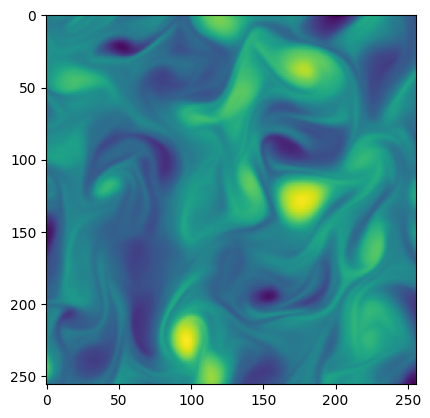

In [18]:
'''
Generating (inferencing) new samples
'''
def denoise(x_t, model, steps=1000):

    betas = torch.linspace(1e-4, 0.02, steps).to(device)
    alphas = 1 - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)

    for t in reversed(range(steps)):
        alpha_t_bar = alphas_cumprod[t]
        beta_t = betas[t]
        alpha_t = alphas[t]
        nomalized_t = t / (steps)
        time_step_channel = torch.ones_like(x_t) * nomalized_t
        time_step_channel = time_step_channel.to(device)
        x_t_with_time_step = torch.cat((x_t, time_step_channel), dim=1)

        # Predict the noise using the model
        with torch.no_grad():
            epsilon_theta = model(x_t_with_time_step)

        # Calculate the mean
        mean = (1 / torch.sqrt(alpha_t)) * (x_t - (beta_t / torch.sqrt(1 - alpha_t_bar)) * epsilon_theta)
        

        
        # Add noise for all but the last step
        if t > 0:
            z = torch.randn_like(x_t).to(device)
            x_t = mean + torch.sqrt(beta_t) * z
        else:
            x_t = mean

    return x_t

# Generate a sample noise image and denoise it
model.eval()


sample_noise = torch.randn(1, 1, 256, 256).to(device)
generated_image = denoise(sample_noise, model)

plt.imshow(generated_image.squeeze().cpu())
plt.show()


In [40]:
print(optimizer.state_dict())

{'state': {0: {'step': tensor(29228.), 'exp_avg': tensor([[[[ 1.4490e-06,  4.0381e-06, -1.7449e-06],
          [ 3.1337e-07,  2.0087e-06, -5.9914e-07],
          [ 1.5499e-06, -8.8356e-08, -4.0897e-06]],

         [[-2.1479e-07, -2.8253e-07,  3.9116e-07],
          [ 3.4179e-07,  2.7823e-07,  9.6709e-07],
          [ 5.4057e-07,  4.7298e-07,  1.1680e-06]]],


        [[[-1.5872e-06, -1.9348e-06,  1.6024e-07],
          [-2.1563e-06, -4.0808e-06, -2.0054e-06],
          [-2.4688e-06, -3.0753e-06, -1.8595e-06]],

         [[ 2.3278e-07,  1.3566e-07,  7.5425e-08],
          [ 2.5092e-07,  1.5328e-07,  9.5011e-08],
          [ 3.0452e-07,  2.1283e-07,  1.5523e-07]]],


        [[[ 3.9070e-08, -1.4049e-06, -9.0859e-07],
          [ 1.4995e-06, -1.3166e-06, -8.6351e-07],
          [-1.0063e-06, -1.5839e-06, -3.4821e-07]],

         [[-1.9920e-07, -1.8566e-07, -2.2233e-08],
          [-1.7456e-07, -1.5961e-07,  5.2609e-10],
          [-1.2995e-07, -1.1351e-07,  4.9483e-08]]],


        ...,



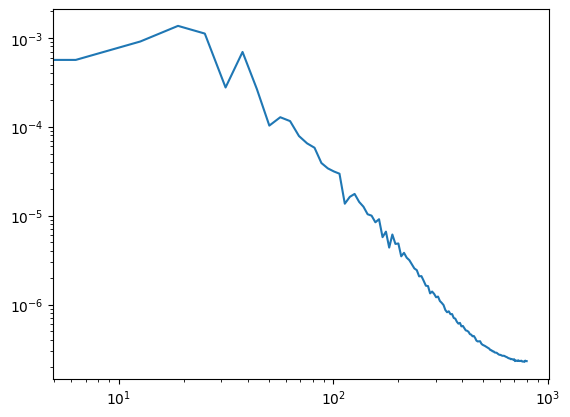

In [20]:
from energy_spectrum import compute_tke_spectrum
_, wavenumbers, spectrum = compute_tke_spectrum(generated_image.detach().squeeze().cpu().numpy(),1,1)
fig,ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(wavenumbers[:128], spectrum[:128])